In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
# Download latest version of hospital dataset
import kagglehub

path = kagglehub.dataset_download("noeyislearning/weekly-hospital-respiratory-data-and-metrics")
# Print the path for the dataset
print("Path to dataset files:", path)

/Users/chicheng/Documents/Dev/interview/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 1.09M/1.09M [00:00<00:00, 2.06MB/s]

Extracting files...


In [4]:
# Read the data
csv_path = 'data/raw_weekly_hospital_respiratory_data_2020_2024.csv'

# Read the CSV into a DataFrame
df = pd.read_csv(csv_path)

# Display the first few rows to verify
df.head()

,Week Ending Date,Geographic aggregation,Number of Inpatient Beds,Number of Adult Inpatient Beds,Number of Pediatric Inpatient beds,Number of Inpatient Beds Occupied,Number of Adult Inpatient Beds Occupied,Number of Pediatric Inpatient Beds Occupied,Number of ICU Beds,Number of Adult ICU Beds,...,Absolute Change in the Percent Hospitals Reporting Adult RSV Admissions from Prior Week,Absolute Change in the Percent Hospitals Reporting RSV Admissions from Prior Week,Absolute Change in the Percent Hospitals Reporting Percent Inpatient Beds Occupied from Prior Week,Absolute Change in the Percent Hospitals Reporting Percent ICU Beds Occupied from Prior Week,Absolute Change in the Percent Hospitals Reporting Percent Inpatient Beds Occupied by COVID-19 Patients from Prior Week,Absolute Change in the Percent Hospitals Reporting Percent Inpatient Beds Occupied by Influenza Patients from Prior Week,Absolute Change in the Percent Hospitals Reporting Percent Inpatient Beds Occupied by RSV Patients from Prior Week,Absolute Change in the Percent Hospitals Reporting Percent ICU Beds Occupied by COVID-19 Patients from Prior Week,Absolute Change in the Percent Hospitals Reporting Percent ICU Beds Occupied by Influenza Patients from Prior Week,Absolute Change in the Percent Hospitals Reporting Percent ICU Beds Occupied by RSV Patients from Prior Week
0,2023-08-12,WA,10650.0,9282.0,482.0,9040.0,8117.0,339.0,1623.0,1059.0,...,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0
1,2023-08-12,WI,10752.0,9824.0,425.0,7574.0,7027.0,286.0,1566.0,1232.0,...,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0
2,2023-08-12,WV,4813.0,4556.0,256.0,3701.0,3562.0,139.0,639.0,595.0,...,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0
3,2023-08-12,WY,1318.0,1142.0,25.0,559.0,534.0,6.0,114.0,109.0,...,0.0,0.0,0.03,0.03,0.03,0.03,0.0,0.03,0.03,0.0
4,2023-08-19,AK,1354.0,1192.0,77.0,1054.0,939.0,43.0,184.0,126.0,...,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0


In [5]:
# Necessary data check before EDA, Data Inspection and Preprocessing
# Display the number of rows and columns
print(f"Number of Rows: {df.shape[0]}")
print(f"Number of Columns: {df.shape[1]}")

Number of Rows: 12768
Number of Columns: 157


In [ ]:
# List all column names
print(df.columns.tolist())

['Week Ending Date', 'Geographic aggregation', 'Number of Inpatient Beds', 'Number of Adult Inpatient Beds', 'Number of Pediatric Inpatient beds', 'Number of Inpatient Beds Occupied', 'Number of Adult Inpatient Beds Occupied', 'Number of Pediatric Inpatient Beds Occupied', 'Number of ICU Beds', 'Number of Adult ICU Beds', 'Number of Pediatric ICU Beds', 'Number of ICU Beds Occupied', 'Number of Adult ICU Beds Occupied', 'Number of Pediatric ICU Beds Occupied', 'Number of Adult Patients Hospitalized with COVID-19', 'Number of Pediatric Patients Hospitalized with COVID-19', 'Total Patients Hospitalized with COVID-19', 'Number of Adult Patients Hospitalized with Influenza', 'Number of Pedatric Patients Hospitalized with Influenza', 'Total Patients Hospitalized with Influenza', 'Number of Adult Patients Hospitalized with RSV', 'Number of Pediatric Patients Hospitalized with RSV', 'Total Patients Hospitalized with RSV', 'Number of Adult ICU Patients Hospitalized with COVID-19', 'Number of P

In [14]:
# Enumerate columns starting from 1
for idx, column in enumerate(df.columns, 1):
    print(f"{idx}: {column}")

1: Week Ending Date
2: Geographic aggregation
3: Number of Inpatient Beds
4: Number of Adult Inpatient Beds
5: Number of Pediatric Inpatient beds
6: Number of Inpatient Beds Occupied
7: Number of Adult Inpatient Beds Occupied
8: Number of Pediatric Inpatient Beds Occupied
9: Number of ICU Beds
10: Number of Adult ICU Beds
11: Number of Pediatric ICU Beds
12: Number of ICU Beds Occupied
13: Number of Adult ICU Beds Occupied
14: Number of Pediatric ICU Beds Occupied
15: Number of Adult Patients Hospitalized with COVID-19
16: Number of Pediatric Patients Hospitalized with COVID-19
17: Total Patients Hospitalized with COVID-19
18: Number of Adult Patients Hospitalized with Influenza
19: Number of Pedatric Patients Hospitalized with Influenza
20: Total Patients Hospitalized with Influenza
21: Number of Adult Patients Hospitalized with RSV
22: Number of Pediatric Patients Hospitalized with RSV
23: Total Patients Hospitalized with RSV
24: Number of Adult ICU Patients Hospitalized with COVID-1

In [7]:
# Display data types of each column
print(df.dtypes)

Week Ending Date                                                                                                             object
Geographic aggregation                                                                                                       object
Number of Inpatient Beds                                                                                                    float64
Number of Adult Inpatient Beds                                                                                              float64
Number of Pediatric Inpatient beds                                                                                          float64
                                                                                                                             ...   
Absolute Change in the Percent Hospitals Reporting Percent Inpatient Beds Occupied by Influenza Patients from Prior Week    float64
Absolute Change in the Percent Hospitals Reporting Percent Inpatient Beds Oc

In [10]:
# Example: Convert 'Date' column to datetime
df['Week Ending Date'] = pd.to_datetime(df['Week Ending Date'], errors='coerce')

# Example: Convert 'Category' column to category type
df['Geographic aggregation'] = df['Geographic aggregation'].astype('category')

# Print data types
print(df.dtypes)

Week Ending Date                                                                                                            datetime64[ns]
Geographic aggregation                                                                                                            category
Number of Inpatient Beds                                                                                                           float64
Number of Adult Inpatient Beds                                                                                                     float64
Number of Pediatric Inpatient beds                                                                                                 float64
                                                                                                                                 ...      
Absolute Change in the Percent Hospitals Reporting Percent Inpatient Beds Occupied by Influenza Patients from Prior Week           float64
Absolute Change in the Perc

In [11]:
df.head(10)

,Week Ending Date,Geographic aggregation,Number of Inpatient Beds,Number of Adult Inpatient Beds,Number of Pediatric Inpatient beds,Number of Inpatient Beds Occupied,Number of Adult Inpatient Beds Occupied,Number of Pediatric Inpatient Beds Occupied,Number of ICU Beds,Number of Adult ICU Beds,...,Absolute Change in the Percent Hospitals Reporting Adult RSV Admissions from Prior Week,Absolute Change in the Percent Hospitals Reporting RSV Admissions from Prior Week,Absolute Change in the Percent Hospitals Reporting Percent Inpatient Beds Occupied from Prior Week,Absolute Change in the Percent Hospitals Reporting Percent ICU Beds Occupied from Prior Week,Absolute Change in the Percent Hospitals Reporting Percent Inpatient Beds Occupied by COVID-19 Patients from Prior Week,Absolute Change in the Percent Hospitals Reporting Percent Inpatient Beds Occupied by Influenza Patients from Prior Week,Absolute Change in the Percent Hospitals Reporting Percent Inpatient Beds Occupied by RSV Patients from Prior Week,Absolute Change in the Percent Hospitals Reporting Percent ICU Beds Occupied by COVID-19 Patients from Prior Week,Absolute Change in the Percent Hospitals Reporting Percent ICU Beds Occupied by Influenza Patients from Prior Week,Absolute Change in the Percent Hospitals Reporting Percent ICU Beds Occupied by RSV Patients from Prior Week
0,2023-08-12,WA,10650.0,9282.0,482.0,9040.0,8117.0,339.0,1623.0,1059.0,...,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0
1,2023-08-12,WI,10752.0,9824.0,425.0,7574.0,7027.0,286.0,1566.0,1232.0,...,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0
2,2023-08-12,WV,4813.0,4556.0,256.0,3701.0,3562.0,139.0,639.0,595.0,...,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0
3,2023-08-12,WY,1318.0,1142.0,25.0,559.0,534.0,6.0,114.0,109.0,...,0.0,0.0,0.03,0.03,0.03,0.03,0.0,0.03,0.03,0.0
4,2023-08-19,AK,1354.0,1192.0,77.0,1054.0,939.0,43.0,184.0,126.0,...,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0
5,2023-08-19,AL,12977.0,12059.0,510.0,9760.0,9128.0,286.0,1668.0,1548.0,...,0.0,0.0,0.00,0.00,0.00,0.02,0.0,0.00,0.02,0.0
6,2023-08-19,AR,7453.0,6803.0,427.0,5201.0,4724.0,295.0,1143.0,865.0,...,0.0,0.0,0.00,0.00,0.00,0.02,0.0,0.00,0.02,0.0
7,2023-08-19,AS,150.0,122.0,28.0,63.0,50.0,7.0,7.0,7.0,...,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0
8,2023-08-19,AZ,13553.0,11871.0,873.0,10426.0,9320.0,596.0,2026.0,1524.0,...,0.0,0.0,0.00,0.00,0.00,0.02,0.0,0.00,0.02,0.0
9,2023-08-19,CA,60469.0,54697.0,4188.0,46531.0,42826.0,2619.0,9795.0,6490.0,...,0.0,0.0,0.00,0.00,0.00,0.02,0.0,0.00,0.02,0.0


In [16]:
# Search for columns containing 'Total ICU Patients Hospitalized'
matching_columns = [col for col in df.columns if 'Total ICU Patients Hospitalized' in col]
print("Matching Columns:", matching_columns)

Matching Columns: ['Total ICU Patients Hospitalized with COVID-19 ', 'Total ICU Patients Hospitalized with Influenza', 'Total ICU Patients Hospitalized with RSV']


In [17]:
# Subset the data
desired_columns = [
    'Week Ending Date',
    'Geographic aggregation',
    'Number of Inpatient Beds',
    'Number of Inpatient Beds Occupied',
    'Number of ICU Beds',
    'Number of ICU Beds Occupied',
    'Total Patients Hospitalized with COVID-19',
    'Total Patients Hospitalized with Influenza',
    'Total Patients Hospitalized with RSV',
    'Total ICU Patients Hospitalized with COVID-19 ',
    'Total ICU Patients Hospitalized with Influenza',
    'Total ICU Patients Hospitalized with RSV'
]

# Subset the DataFrame to keep only the desired columns
df_subset = df[desired_columns]

# Display the first few rows of the subset DataFrame
df_subset.head()

,Week Ending Date,Geographic aggregation,Number of Inpatient Beds,Number of Inpatient Beds Occupied,Number of ICU Beds,Number of ICU Beds Occupied,Total Patients Hospitalized with COVID-19,Total Patients Hospitalized with Influenza,Total Patients Hospitalized with RSV,Total ICU Patients Hospitalized with COVID-19,Total ICU Patients Hospitalized with Influenza,Total ICU Patients Hospitalized with RSV
0,2023-08-12,WA,10650.0,9040.0,1623.0,1309.0,226.0,17.0,NaN,25.0,0.0,NaN
1,2023-08-12,WI,10752.0,7574.0,1566.0,1014.0,86.0,2.0,NaN,12.0,0.0,NaN
2,2023-08-12,WV,4813.0,3701.0,639.0,468.0,47.0,1.0,NaN,9.0,0.0,NaN
3,2023-08-12,WY,1318.0,559.0,114.0,40.0,4.0,1.0,NaN,0.0,0.0,NaN
4,2023-08-19,AK,1354.0,1054.0,184.0,139.0,12.0,0.0,NaN,1.0,0.0,NaN


In [20]:
# Remove leading and trailing spaces from all column names
df_subset.columns = df_subset.columns.str.strip()

for idx, column in enumerate(df_subset.columns, 1):
    print(f"{idx}: {column}")

1: Week Ending Date
2: Geographic aggregation
3: Number of Inpatient Beds
4: Number of Inpatient Beds Occupied
5: Number of ICU Beds
6: Number of ICU Beds Occupied
7: Total Patients Hospitalized with COVID-19
8: Total Patients Hospitalized with Influenza
9: Total Patients Hospitalized with RSV
10: Total ICU Patients Hospitalized with COVID-19
11: Total ICU Patients Hospitalized with Influenza
12: Total ICU Patients Hospitalized with RSV


In [21]:
# Count of missing values in each column
missing_values = df_subset.isnull().sum()
print(missing_values)

Week Ending Date                                      0
Geographic aggregation                                0
Number of Inpatient Beds                            247
Number of Inpatient Beds Occupied                   247
Number of ICU Beds                                  247
Number of ICU Beds Occupied                         247
Total Patients Hospitalized with COVID-19           260
Total Patients Hospitalized with Influenza          756
Total Patients Hospitalized with RSV              10656
Total ICU Patients Hospitalized with COVID-19       271
Total ICU Patients Hospitalized with Influenza      748
Total ICU Patients Hospitalized with RSV          10656
dtype: int64


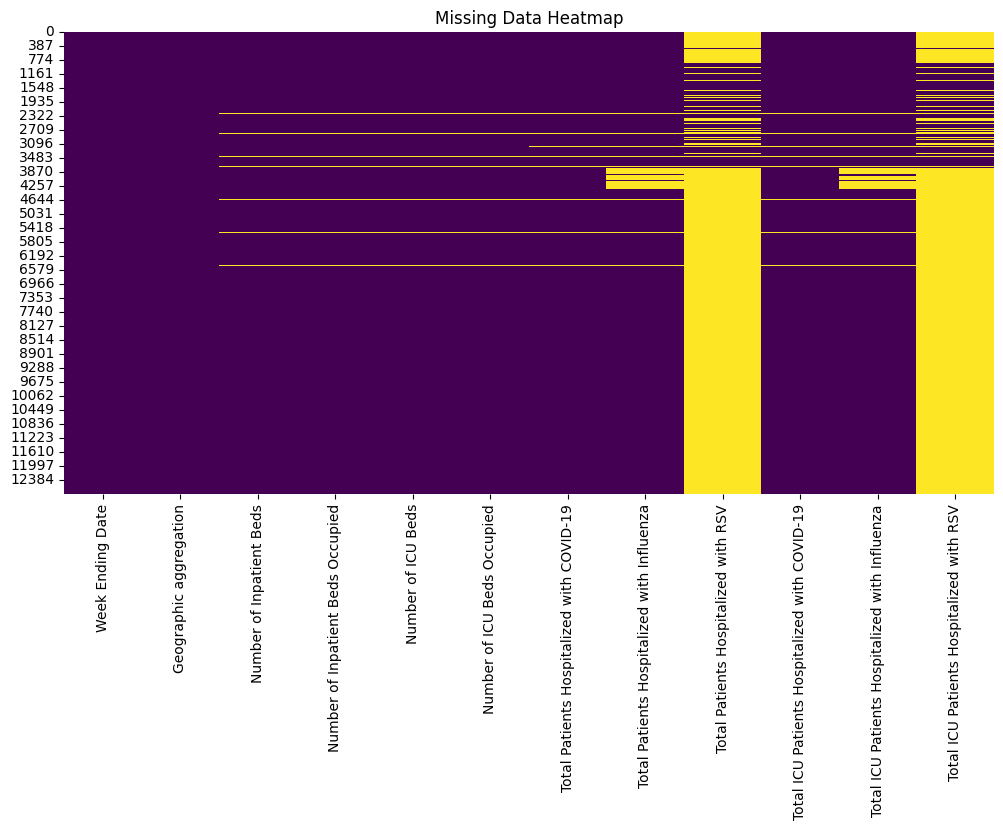

In [22]:
plt.figure(figsize=(12, 6))
sns.heatmap(df_subset.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [24]:
df_subset.dtypes

Week Ending Date                                  datetime64[ns]
Geographic aggregation                                  category
Number of Inpatient Beds                                 float64
Number of Inpatient Beds Occupied                        float64
Number of ICU Beds                                       float64
Number of ICU Beds Occupied                              float64
Total Patients Hospitalized with COVID-19                float64
Total Patients Hospitalized with Influenza               float64
Total Patients Hospitalized with RSV                     float64
Total ICU Patients Hospitalized with COVID-19            float64
Total ICU Patients Hospitalized with Influenza           float64
Total ICU Patients Hospitalized with RSV                 float64
dtype: object

/var/folders/m7/9_frjjyx2mlb_s51nv_8v3rm0000gn/T/ipykernel_65988/3800095262.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['Date'] = pd.to_datetime(df_subset['Week Ending Date'])


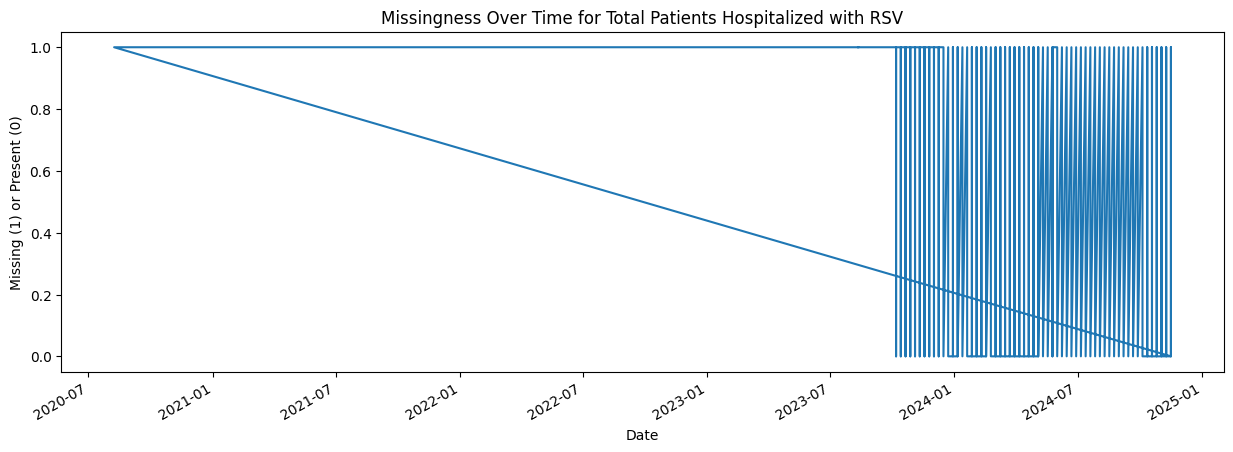

In [27]:
# Identify the most effecient way to impute the missing value
# Plot missingness for a specific column
df_subset['Date'] = pd.to_datetime(df_subset['Week Ending Date'])
df_subset.set_index('Date', inplace=True)

plt.figure(figsize=(15, 5))
df_subset['Total Patients Hospitalized with RSV'].isnull().astype(int).plot()
plt.title('Missingness Over Time for Total Patients Hospitalized with RSV')
plt.xlabel('Date')
plt.ylabel('Missing (1) or Present (0)')
plt.show()

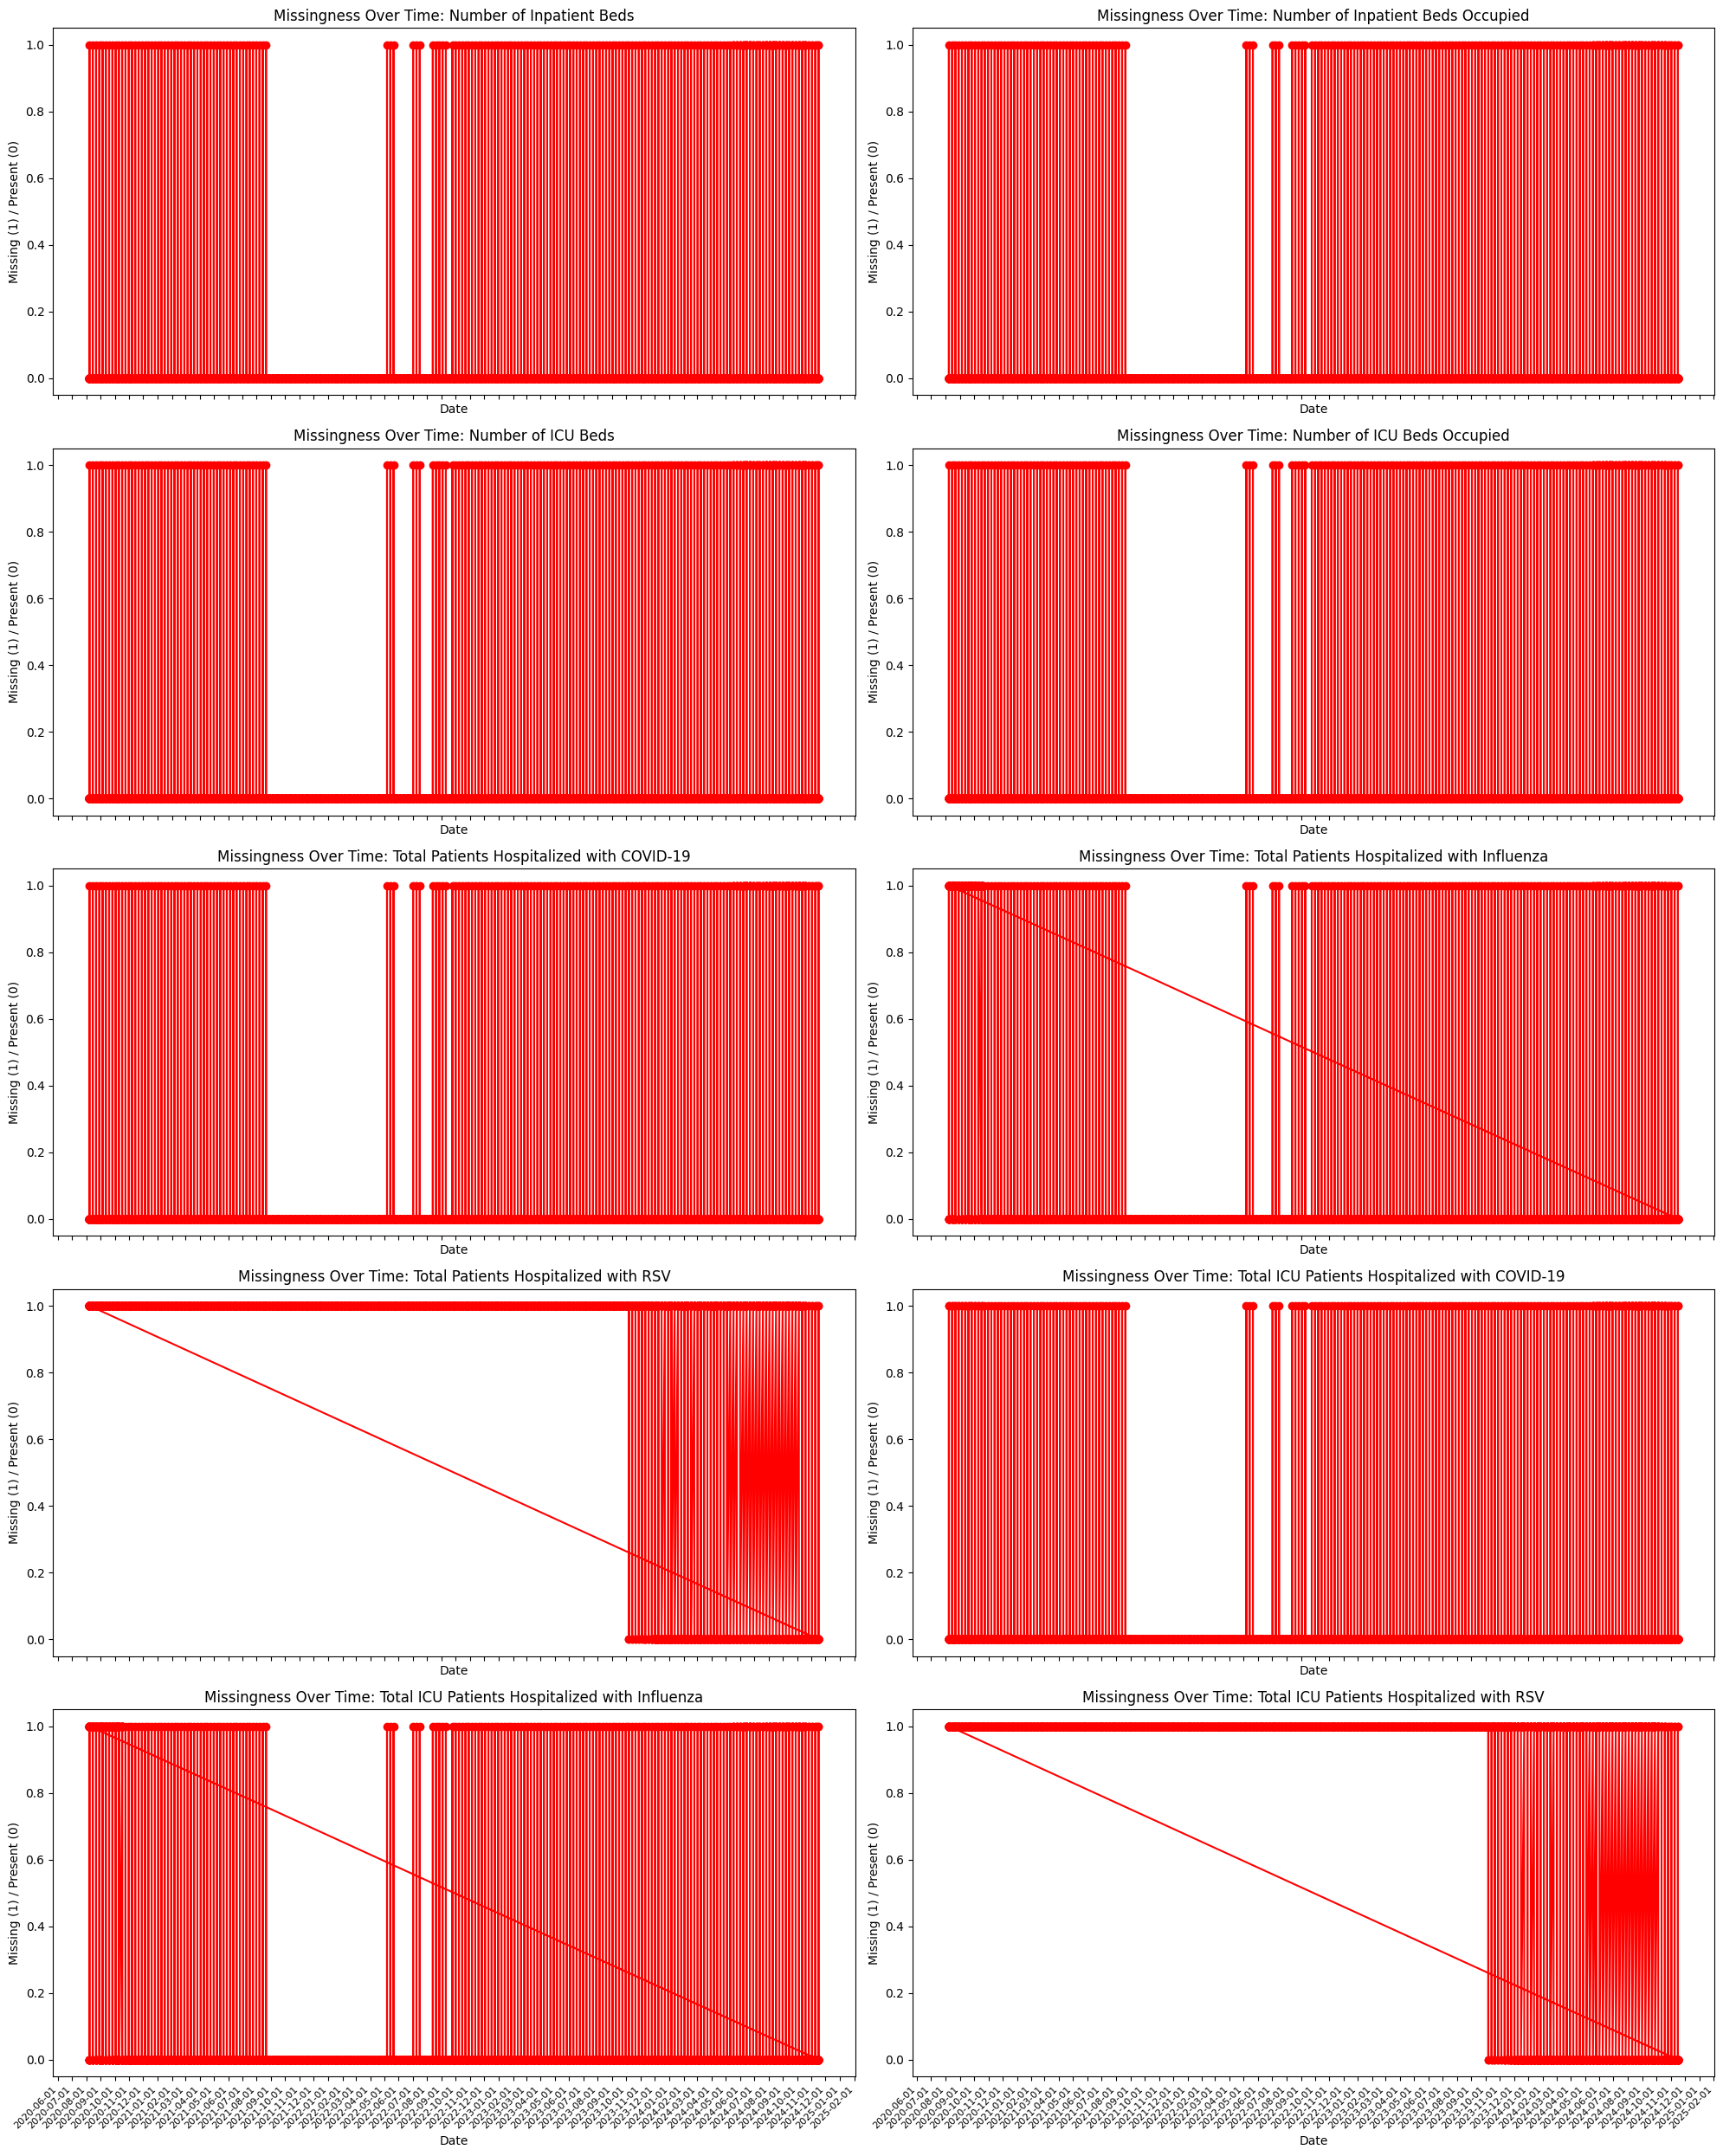

In [30]:
# List of numeric columns to visualize missingness
numeric_columns = [
    'Number of Inpatient Beds',
    'Number of Inpatient Beds Occupied',
    'Number of ICU Beds',
    'Number of ICU Beds Occupied',
    'Total Patients Hospitalized with COVID-19',
    'Total Patients Hospitalized with Influenza',
    'Total Patients Hospitalized with RSV',
    'Total ICU Patients Hospitalized with COVID-19',
    'Total ICU Patients Hospitalized with Influenza',
    'Total ICU Patients Hospitalized with RSV'
]

# Number of plots
num_plots = len(numeric_columns)

# Determine grid size (e.g., 5 rows x 2 columns)
rows = 5
cols = 2

# Create a figure and axes
fig, axes = plt.subplots(rows, cols, figsize=(20, 25), sharex=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through each column and create a plot
for idx, column in enumerate(numeric_columns):
    ax = axes[idx]
    
    # Create a binary series: 1 if missing, 0 if present
    missing_series = df_subset[column].isnull().astype(int)
    
    # Plot the missingness
    ax.plot(df_subset.index, missing_series, marker='o', linestyle='-', color='red')
    
    # Set title and labels
    ax.set_title(f'Missingness Over Time: {column}', fontsize=12)
    ax.set_ylabel('Missing (1) / Present (0)', fontsize=10)
    ax.set_xlabel('Date', fontsize=10)
    
    # Improve x-axis date formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)

# Remove any unused subplots (if any)
for i in range(idx + 1, rows * cols):
    fig.delaxes(axes[i])

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [32]:
geography_column = 'Geographic aggregation'

# Group by geography and calculate missing values
missing_by_geography = df.groupby(geography_column)[numeric_columns].apply(lambda x: x.isnull().sum())

# Calculate the total number of possible data points per geography
# Assuming data is recorded weekly, calculate the number of weeks
num_weeks = df.index.nunique()

# Add a total missing count across all columns
missing_by_geography['Total Missing'] = missing_by_geography.sum(axis=1)

# Add a percentage missing
missing_by_geography['Percentage Missing'] = (missing_by_geography['Total Missing'] / (len(numeric_columns) * num_weeks)) * 100

# Reset index for easier handling
missing_by_geography = missing_by_geography.reset_index()

# Display the missingness summary
missing_by_geography

/var/folders/m7/9_frjjyx2mlb_s51nv_8v3rm0000gn/T/ipykernel_65988/710975806.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  missing_by_geography = df.groupby(geography_column)[numeric_columns].apply(lambda x: x.isnull().sum())


,Geographic aggregation,Number of Inpatient Beds,Number of Inpatient Beds Occupied,Number of ICU Beds,Number of ICU Beds Occupied,Total Patients Hospitalized with COVID-19,Total Patients Hospitalized with Influenza,Total Patients Hospitalized with RSV,Total ICU Patients Hospitalized with COVID-19,Total ICU Patients Hospitalized with Influenza,Total ICU Patients Hospitalized with RSV,Total Missing,Percentage Missing
0,AK,0,0,0,0,0,10,202,0,10,201,423,0.331297
1,AL,0,0,0,0,0,11,184,0,11,184,390,0.305451
2,AR,0,0,0,0,0,10,173,0,10,173,366,0.286654
3,AS,77,77,77,77,77,77,222,77,77,222,1060,0.830201
4,AZ,0,0,0,0,0,8,172,0,8,172,360,0.281955
5,CA,0,0,0,0,0,10,172,0,10,172,364,0.285088
6,CO,0,0,0,0,0,10,173,0,10,173,366,0.286654
7,CT,0,0,0,0,0,7,174,0,7,174,362,0.283521
8,DC,0,0,0,0,0,11,201,0,11,201,424,0.332080
9,DE,0,0,0,0,0,11,173,0,11,173,368,0.288221


In [37]:
# Subset the data
desired_columns_2 = [
    'Week Ending Date',
    'Geographic aggregation',
    'Total ICU Patients Hospitalized with COVID-19'
]

# Subset the DataFrame to keep only the desired columns
df_t = df[desired_columns_2]

# Display the first few rows of the subset DataFrame
df_t.head()

,Week Ending Date,Geographic aggregation,Total ICU Patients Hospitalized with COVID-19
0,2023-08-12,WA,25.0
1,2023-08-12,WI,12.0
2,2023-08-12,WV,9.0
3,2023-08-12,WY,0.0
4,2023-08-19,AK,1.0


/var/folders/m7/9_frjjyx2mlb_s51nv_8v3rm0000gn/T/ipykernel_65988/160542161.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_geographies = df.groupby('Geographic aggregation')['Total Patients Hospitalized with COVID-19'].sum().nlargest(10).index.tolist()


<Axes: xlabel='Week Ending Date', ylabel='Total ICU Patients Hospitalized with COVID-19'>

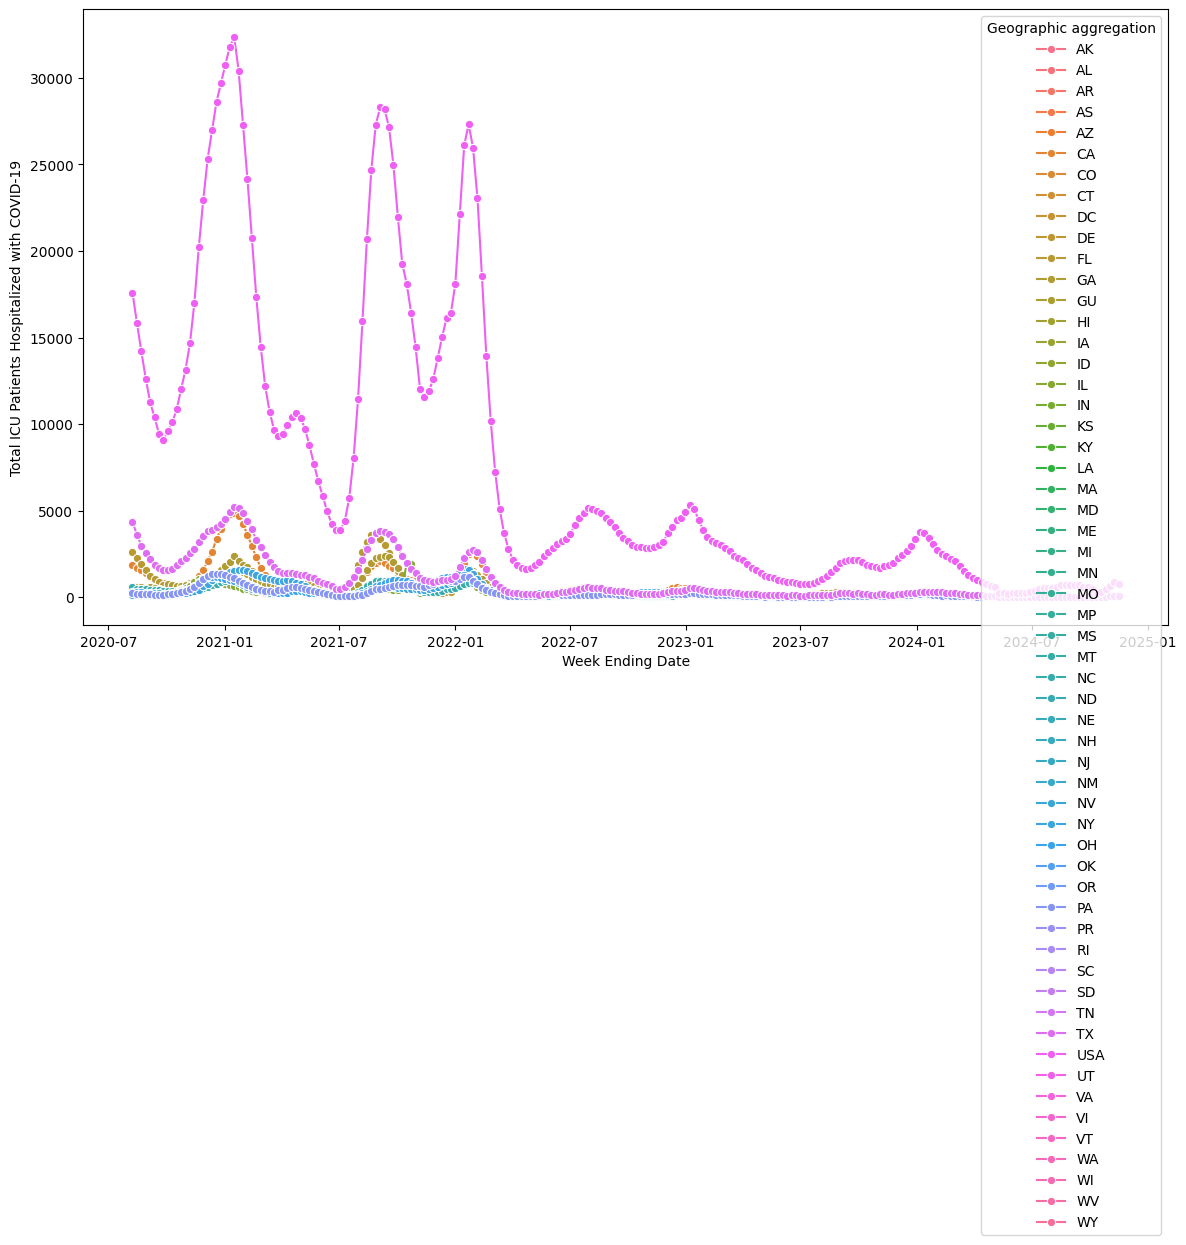

In [44]:
top_geographies = df.groupby('Geographic aggregation')['Total Patients Hospitalized with COVID-19'].sum().nlargest(10).index.tolist()
df_top = df_t[df_t['Geographic aggregation'].isin(top_geographies)]

plt.figure(figsize=(14, 8))
sns.lineplot(
    data=df_top,
    x='Week Ending Date',
    y='Total ICU Patients Hospitalized with COVID-19',
    hue='Geographic aggregation',
    marker='o'
)

In [75]:
# Imputation on Total ICU Patients Hospitalized with COVID-19
# Sample DataFrame creation
# Sort the DataFrame by 'Geographic aggregation' and 'Week Ending Date'
df_sorted = df_t.sort_values(['Geographic aggregation', 'Week Ending Date'])

# Apply forward fill and backward fill within each geographic group
df_sorted['Imputed COVID-19 Inpatients'] = (
    df_sorted
    .groupby('Geographic aggregation')['Total ICU Patients Hospitalized with COVID-19']
    .fillna(method='ffill')
    .fillna(method='bfill')
)

# Display the DataFrame after imputation
print("DataFrame After Grouped Imputation:")
df_sorted.head(100)

DataFrame After Grouped Imputation:


/var/folders/m7/9_frjjyx2mlb_s51nv_8v3rm0000gn/T/ipykernel_65988/2030776724.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('Geographic aggregation')['Total ICU Patients Hospitalized with COVID-19']
/var/folders/m7/9_frjjyx2mlb_s51nv_8v3rm0000gn/T/ipykernel_65988/2030776724.py:10: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  .fillna(method='ffill')
/var/folders/m7/9_frjjyx2mlb_s51nv_8v3rm0000gn/T/ipykernel_65988/2030776724.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill')
/var/folders/m7

,Week Ending Date,Geographic aggregation,Total ICU Patients Hospitalized with COVID-19,Imputed COVID-19 Inpatients
3766,2020-08-08,AK,10.0,10.0
3823,2020-08-15,AK,11.0,11.0
3880,2020-08-22,AK,14.0,14.0
3937,2020-08-29,AK,18.0,18.0
3994,2020-09-05,AK,16.0,16.0
...,...,...,...,...
9181,2022-06-04,AK,8.0,8.0
9238,2022-06-11,AK,5.0,5.0
9295,2022-06-18,AK,2.0,2.0
9352,2022-06-25,AK,4.0,4.0


In [76]:
df_sorted[df_sorted['Total ICU Patients Hospitalized with COVID-19'].isnull() & df_sorted['Imputed COVID-19 Inpatients'] != 0]

,Week Ending Date,Geographic aggregation,Total ICU Patients Hospitalized with COVID-19,Imputed COVID-19 Inpatients
2248,2024-05-18,MA,NaN,8.0
2305,2024-05-25,MA,NaN,8.0
2362,2024-06-01,MA,NaN,8.0
2419,2024-06-08,MA,NaN,8.0
2476,2024-06-15,MA,NaN,8.0
2533,2024-06-22,MA,NaN,8.0


In [77]:
# Display all rows temporarily
df_sorted[df_sorted['Geographic aggregation']=='MA'].tail(20)

,Week Ending Date,Geographic aggregation,Total ICU Patients Hospitalized with COVID-19,Imputed COVID-19 Inpatients
2647,2024-07-06,MA,0.0,0.0
2704,2024-07-13,MA,0.0,0.0
2761,2024-07-20,MA,0.0,0.0
2818,2024-07-27,MA,NaN,0.0
2875,2024-08-03,MA,NaN,0.0
2932,2024-08-10,MA,NaN,0.0
2989,2024-08-17,MA,NaN,0.0
3046,2024-08-24,MA,NaN,0.0
3103,2024-08-31,MA,NaN,0.0
3160,2024-09-07,MA,NaN,0.0


In [78]:
# Build a time series prediction model
df_sorted.dtypes
df_sorted['Week Ending Date'] = pd.to_datetime(df_sorted['Week Ending Date'])

# Sort the DataFrame by 'Geographic aggregation' and 'Week Ending Date'
df_sorted = df_sorted.sort_values(['Geographic aggregation', 'Week Ending Date'])

# Set 'Week Ending Date' as the index for time series operations
df_sorted.set_index('Week Ending Date', inplace=True)

# Display basic information
print(df_sorted.info())
print(df_sorted.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12768 entries, 2020-08-08 to 2024-11-16
Data columns (total 3 columns):
 #   Column                                         Non-Null Count  Dtype   
---  ------                                         --------------  -----   
 0   Geographic aggregation                         12768 non-null  category
 1   Total ICU Patients Hospitalized with COVID-19  12497 non-null  float64 
 2   Imputed COVID-19 Inpatients                    12768 non-null  float64 
dtypes: category(1), float64(2)
memory usage: 314.2 KB
None
                 Geographic aggregation  \
Week Ending Date                          
2020-08-08                           AK   
2020-08-15                           AK   
2020-08-22                           AK   
2020-08-29                           AK   
2020-09-05                           AK   

                  Total ICU Patients Hospitalized with COVID-19  \
Week Ending Date                                             

In [79]:
# Check for missing values
print(df_sorted.isnull().sum())

Geographic aggregation                             0
Total ICU Patients Hospitalized with COVID-19    271
Imputed COVID-19 Inpatients                        0
dtype: int64


In [82]:
# Create lag features (e.g., past 4 weeks)
lag_steps = [1, 2, 3, 4]
for lag in lag_steps:
    df_sorted[f'lag_{lag}'] = df_sorted.groupby('Geographic aggregation')['Imputed COVID-19 Inpatients'].shift(lag)

# Create rolling mean feature (e.g., 2-week rolling mean)
df_sorted['rolling_mean_2'] = df_sorted.groupby('Geographic aggregation')['Imputed COVID-19 Inpatients'].transform(lambda x: x.rolling(window=2).mean())

# Drop rows with any remaining NaNs due to lagging or rolling
df_model = df_sorted.dropna()
print(df_model.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12277 entries, 2020-09-05 to 2024-11-16
Data columns (total 8 columns):
 #   Column                                         Non-Null Count  Dtype   
---  ------                                         --------------  -----   
 0   Geographic aggregation                         12277 non-null  category
 1   Total ICU Patients Hospitalized with COVID-19  12277 non-null  float64 
 2   Imputed COVID-19 Inpatients                    12277 non-null  float64 
 3   lag_1                                          12277 non-null  float64 
 4   lag_2                                          12277 non-null  float64 
 5   lag_3                                          12277 non-null  float64 
 6   lag_4                                          12277 non-null  float64 
 7   rolling_mean_2                                 12277 non-null  float64 
dtypes: category(1), float64(7)
memory usage: 781.8 KB
None


/var/folders/m7/9_frjjyx2mlb_s51nv_8v3rm0000gn/T/ipykernel_65988/2340444260.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sorted[f'lag_{lag}'] = df_sorted.groupby('Geographic aggregation')['Imputed COVID-19 Inpatients'].shift(lag)
/var/folders/m7/9_frjjyx2mlb_s51nv_8v3rm0000gn/T/ipykernel_65988/2340444260.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sorted[f'lag_{lag}'] = df_sorted.groupby('Geographic aggregation')['Imputed COVID-19 Inpatients'].shift(lag)
/var/folders/m7/9_frjjyx2mlb_s51nv_8v3rm0000gn/T/ipykernel_65988/2340444260.py:4: FutureWarning: The default of observed=False is deprec

In [83]:
df_sorted.head(10)

,Geographic aggregation,Total ICU Patients Hospitalized with COVID-19,Imputed COVID-19 Inpatients,lag_1,lag_2,lag_3,lag_4,rolling_mean_2
Week Ending Date,,,,,,,,
2020-08-08,AK,10.0,10.0,NaN,NaN,NaN,NaN,NaN
2020-08-15,AK,11.0,11.0,10.0,NaN,NaN,NaN,10.5
2020-08-22,AK,14.0,14.0,11.0,10.0,NaN,NaN,12.5
2020-08-29,AK,18.0,18.0,14.0,11.0,10.0,NaN,16.0
2020-09-05,AK,16.0,16.0,18.0,14.0,11.0,10.0,17.0
2020-09-12,AK,22.0,22.0,16.0,18.0,14.0,11.0,19.0
2020-09-19,AK,25.0,25.0,22.0,16.0,18.0,14.0,23.5
2020-09-26,AK,18.0,18.0,25.0,22.0,16.0,18.0,21.5
2020-10-03,AK,11.0,11.0,18.0,25.0,22.0,16.0,14.5


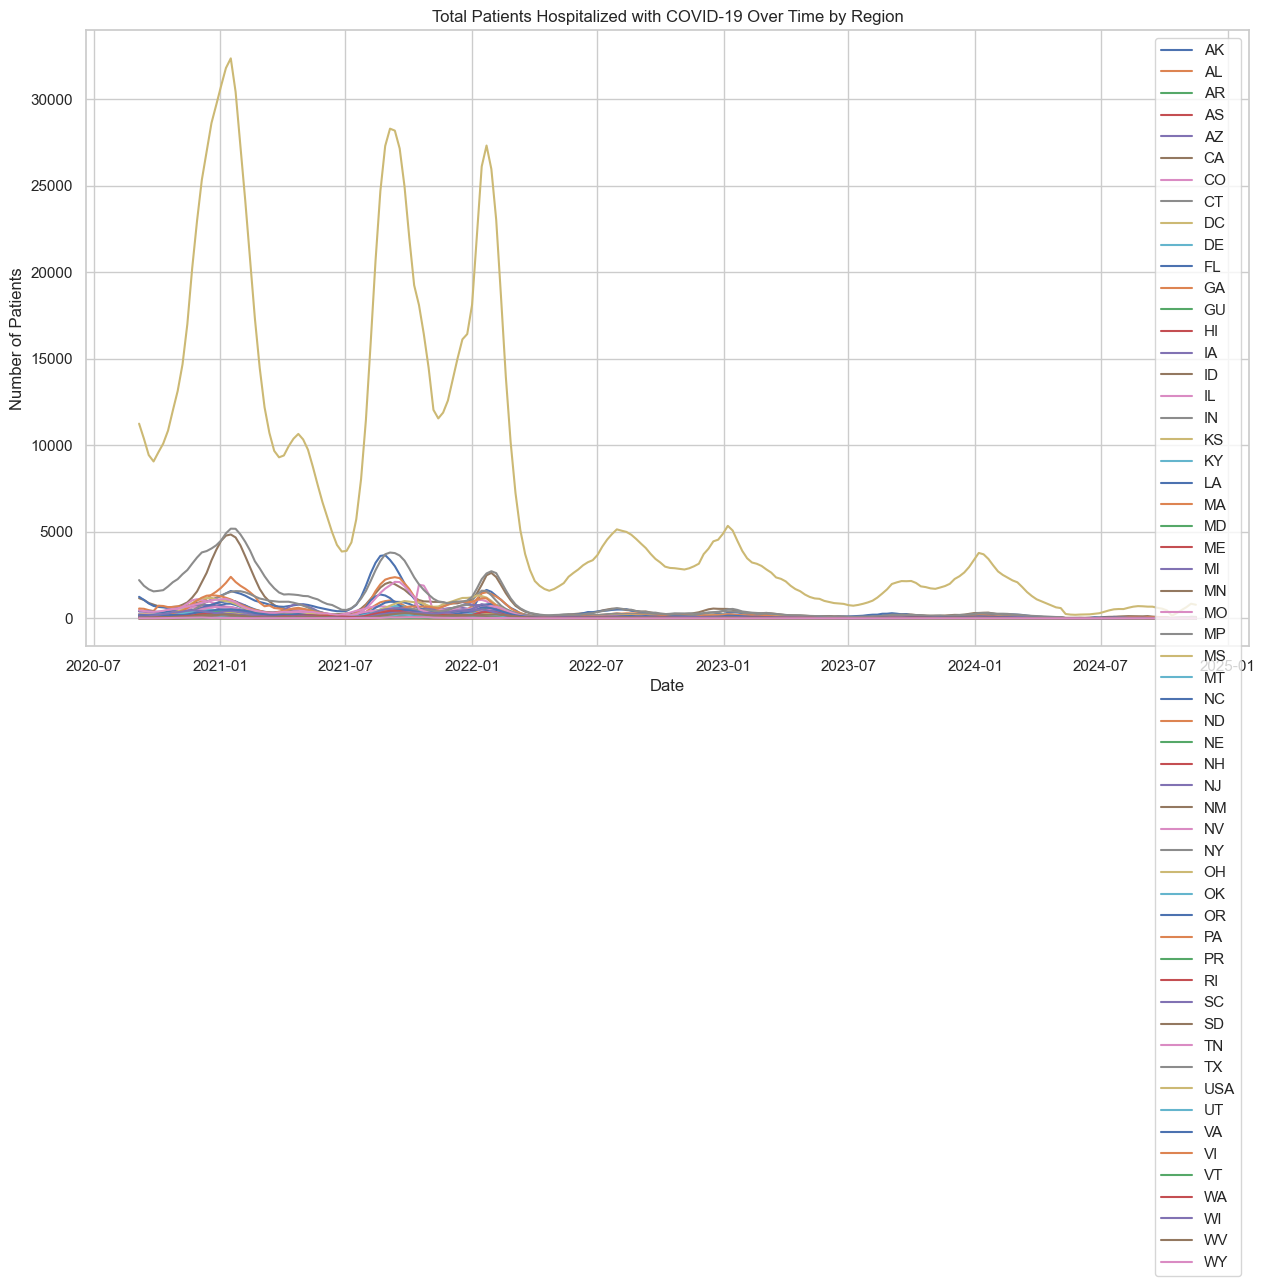

In [84]:
# Set the visual style
sns.set(style="whitegrid")

# Identify unique regions
regions = df_model['Geographic aggregation'].unique()

# Plot time series for each region
plt.figure(figsize=(15, 8))
for region in regions:
    plt.plot(df_model[df_model['Geographic aggregation'] == region].index, 
             df_model[df_model['Geographic aggregation'] == region]['Imputed COVID-19 Inpatients'], 
             label=region)

plt.title('Total Patients Hospitalized with COVID-19 Over Time by Region')
plt.xlabel('Date')
plt.ylabel('Number of Patients')
plt.legend()
plt.show()

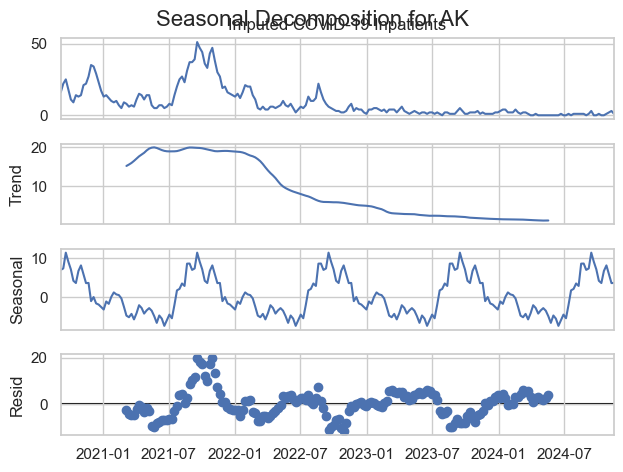

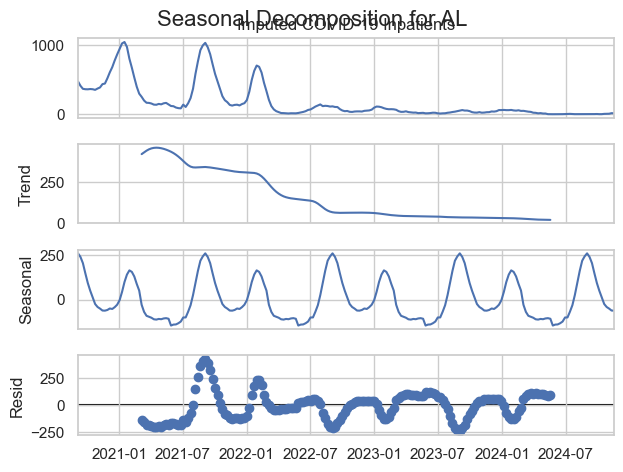

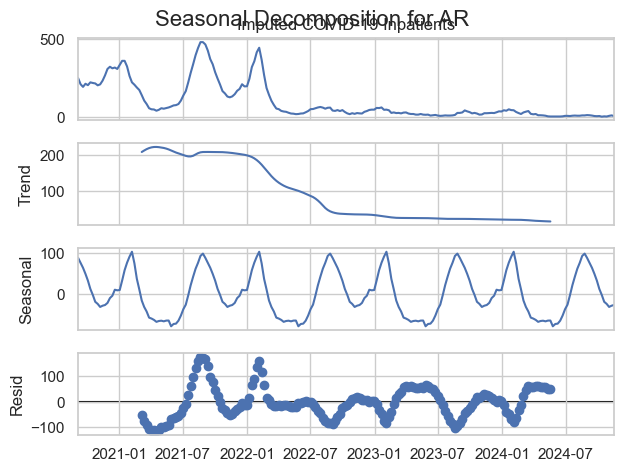

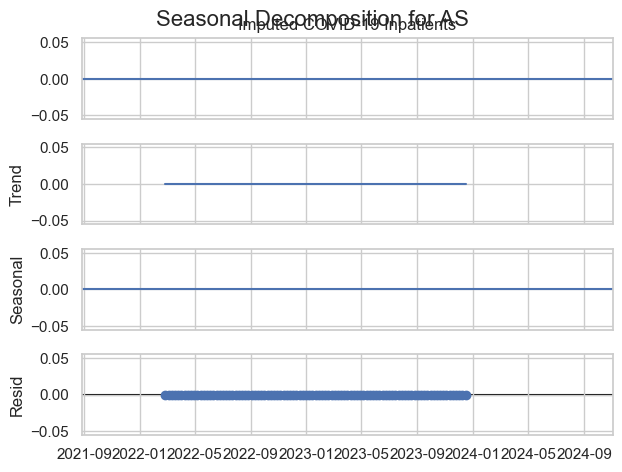

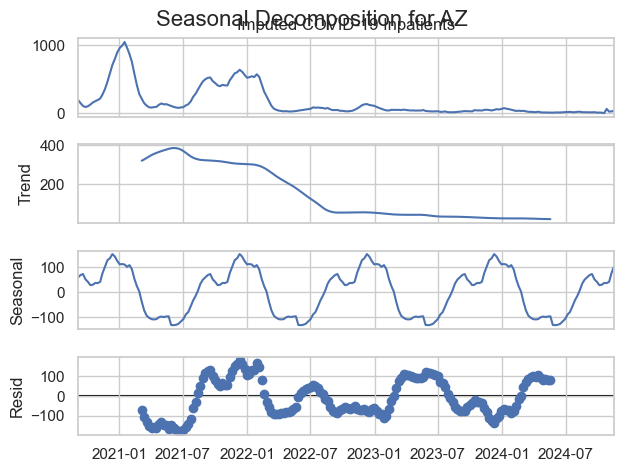

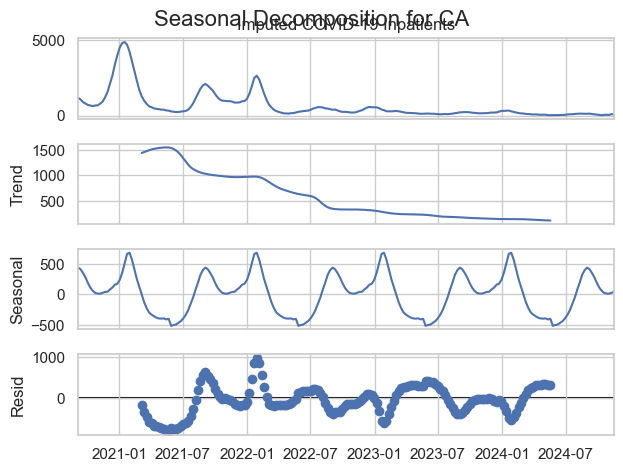

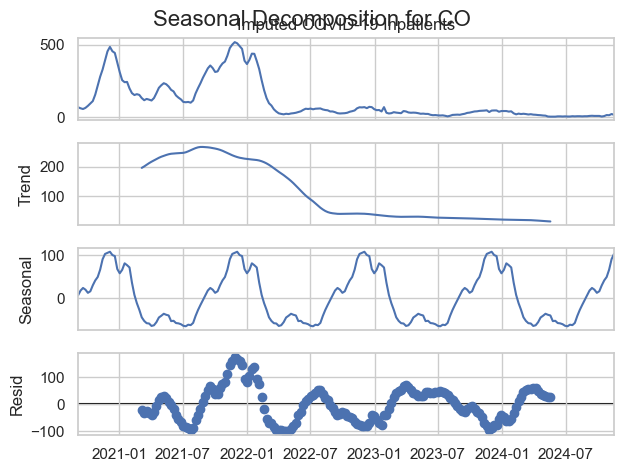

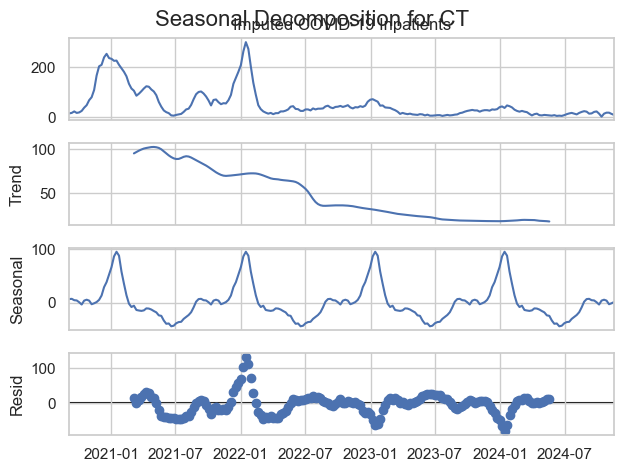

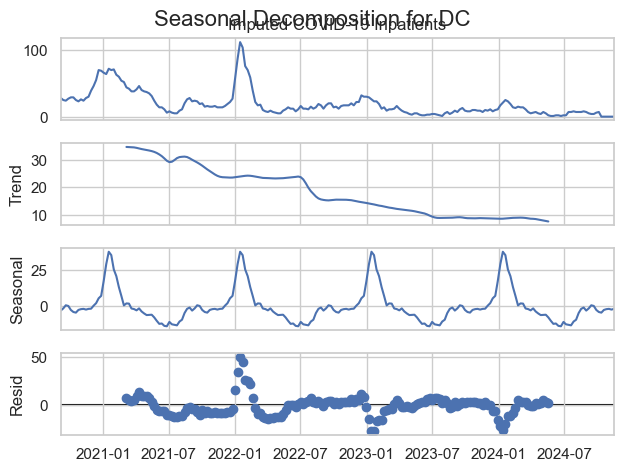

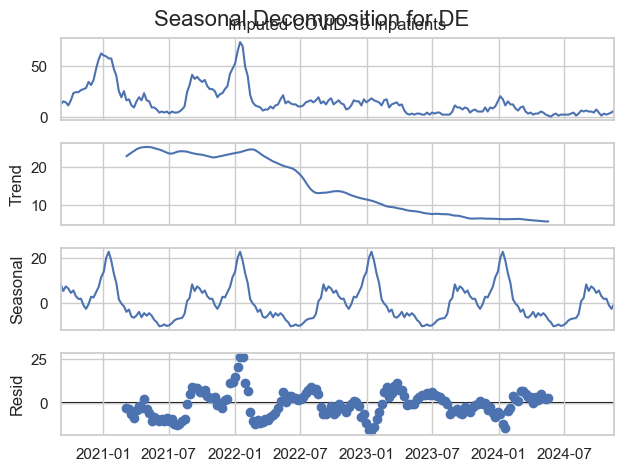

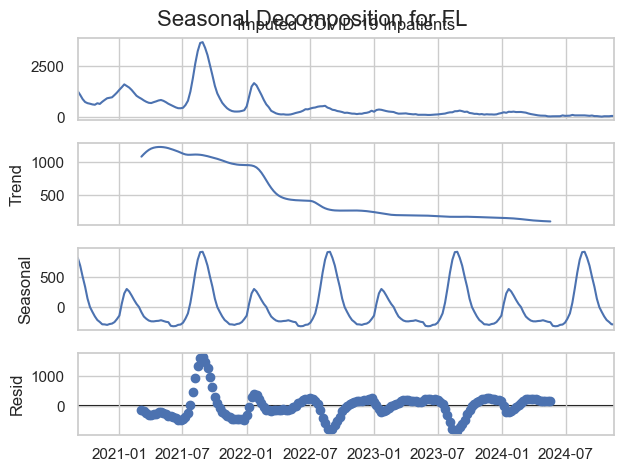

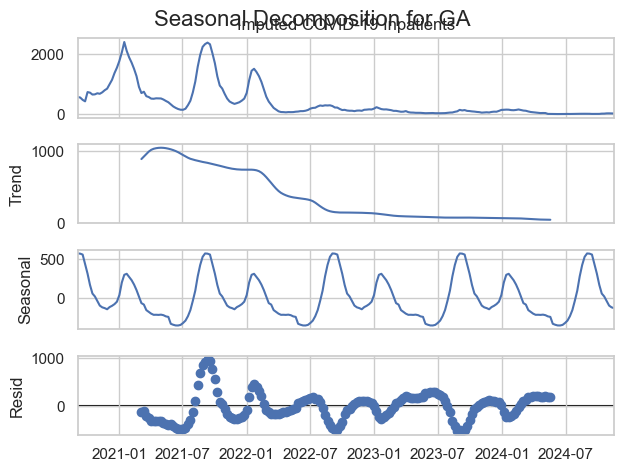

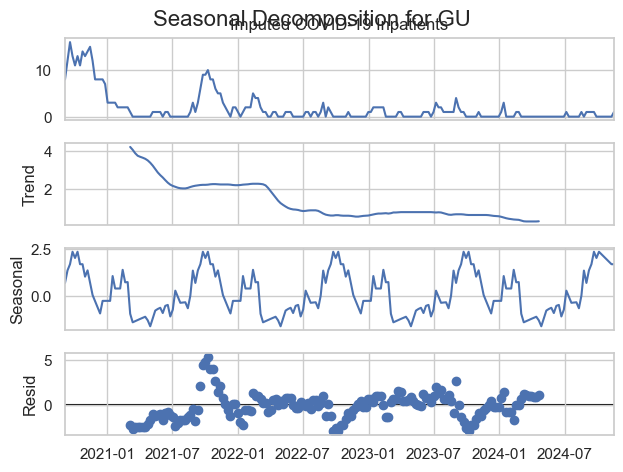

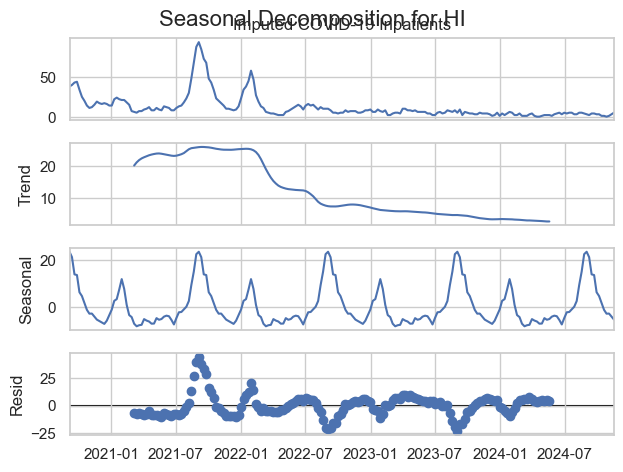

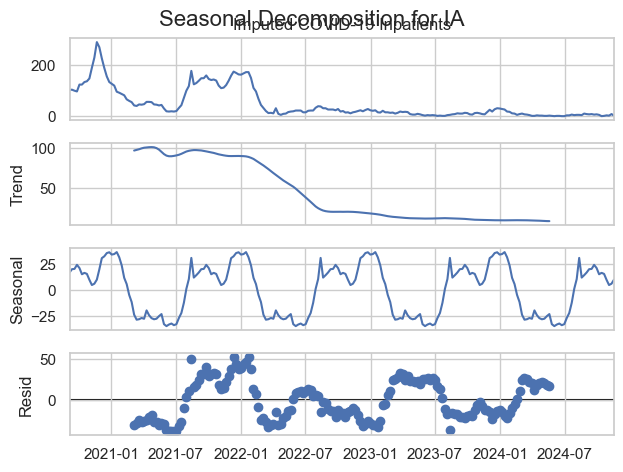

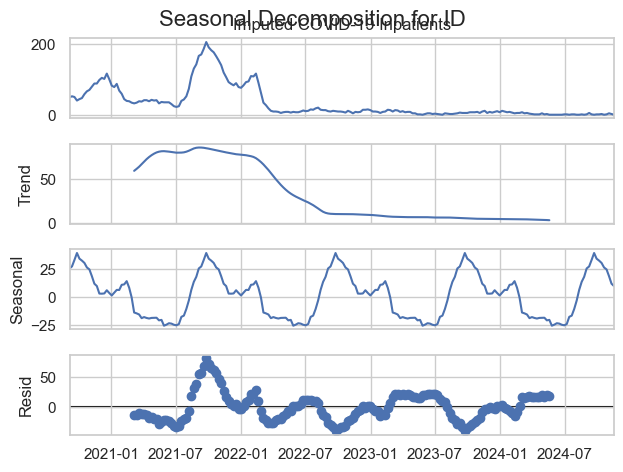

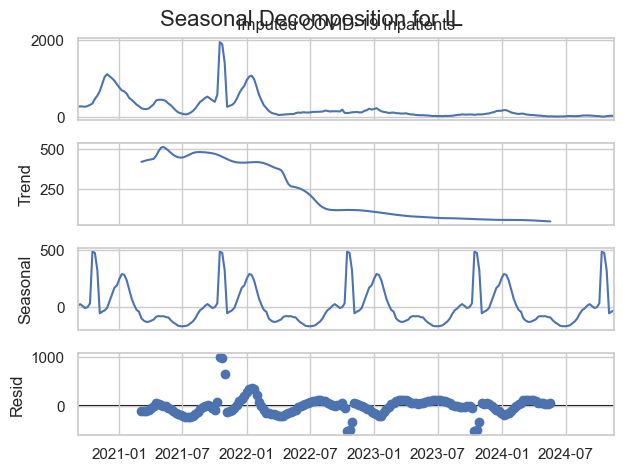

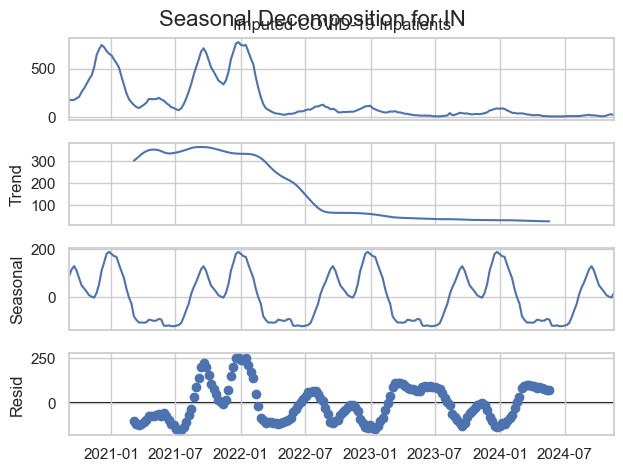

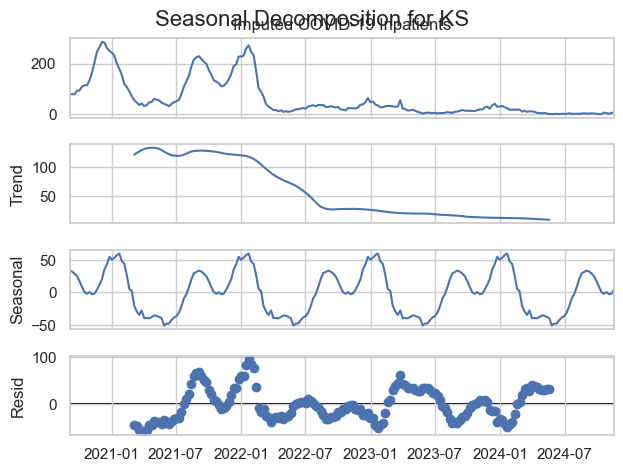

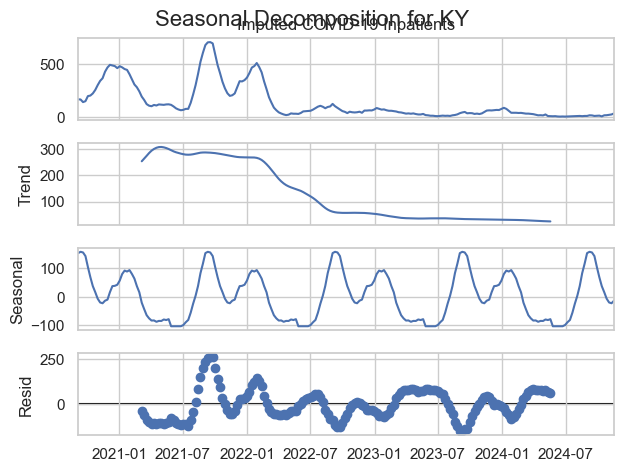

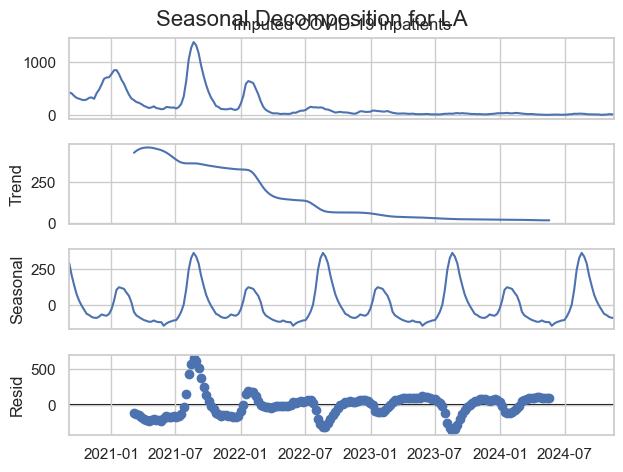

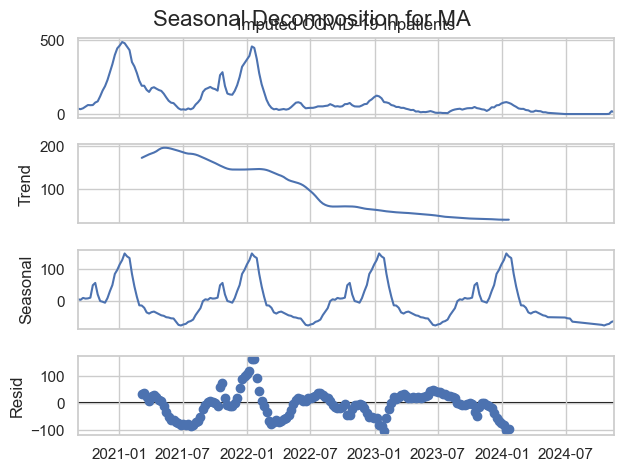

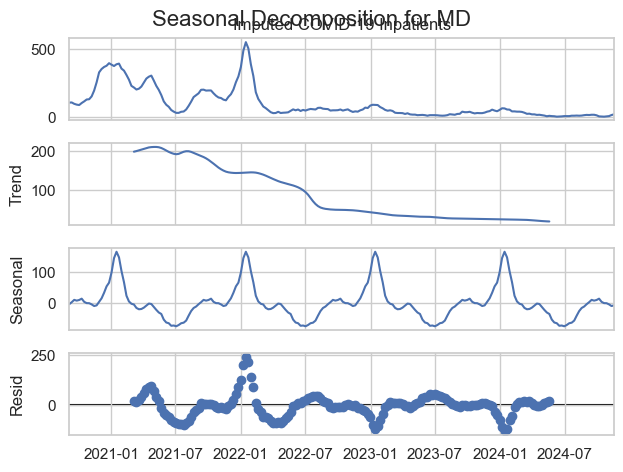

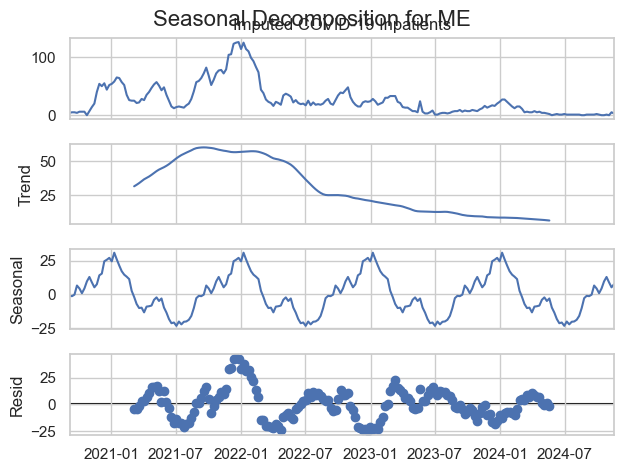

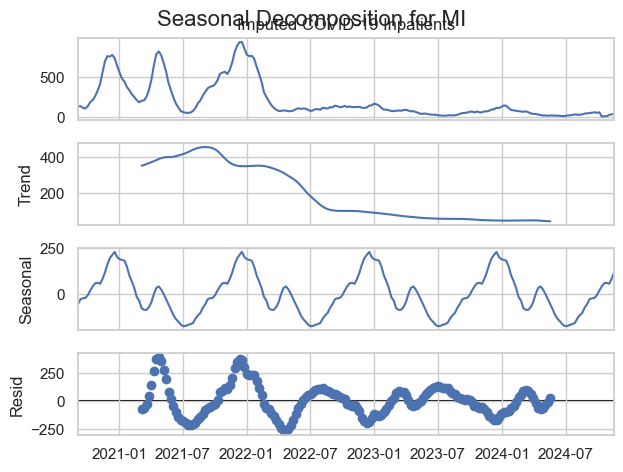

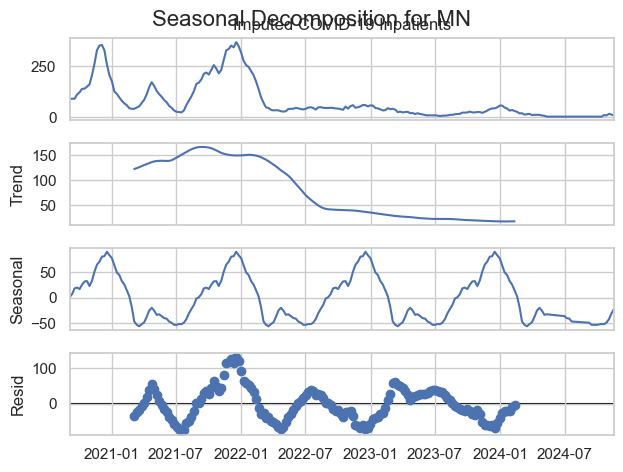

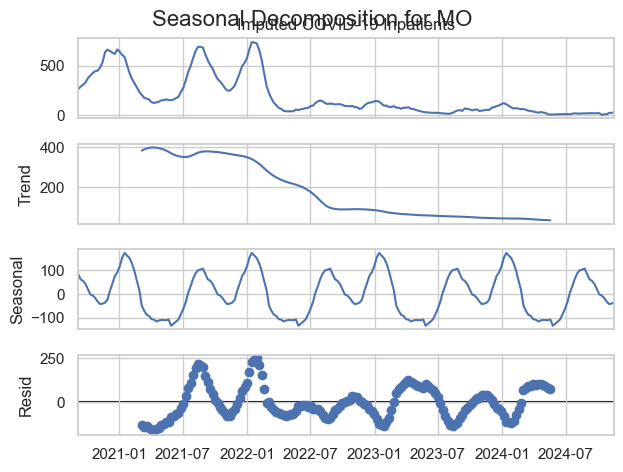

ValueError: x must have 2 complete cycles requires 104 observations. x only has 89 observation(s)

In [86]:
# Decompose time series
from statsmodels.tsa.seasonal import seasonal_decompose

for region in regions:
    ts = df_model[df_model['Geographic aggregation'] == region]['Imputed COVID-19 Inpatients']
    decomposition = seasonal_decompose(ts, model='additive', period=52)  # Adjust 'period' based on seasonality (e.g., weekly data with yearly seasonality)
    decomposition.plot()
    plt.suptitle(f'Seasonal Decomposition for {region}', fontsize=16)
    plt.show()